In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv
/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7

## Importing nessary Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras as kr
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Dense
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score
from os import listdir

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load Data From data set

In [3]:
# Load data
train = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

 # Getting unique tags

In [4]:
# Getting unique tags
train_val = train['tags'].values
split = [x.split(' ') for x in train_val]
lst = []
for sublst in split:
    lst += sublst
labels = list(set(lst))
labels

['road',
 'bare_ground',
 'blooming',
 'agriculture',
 'blow_down',
 'conventional_mine',
 'water',
 'cloudy',
 'artisinal_mine',
 'haze',
 'clear',
 'primary',
 'selective_logging',
 'cultivation',
 'slash_burn',
 'habitation',
 'partly_cloudy']

## Mapping Tags

In [5]:

dic = {}
for x, y in enumerate(labels):
    dic[y] = x
dic


{'road': 0,
 'bare_ground': 1,
 'blooming': 2,
 'agriculture': 3,
 'blow_down': 4,
 'conventional_mine': 5,
 'water': 6,
 'cloudy': 7,
 'artisinal_mine': 8,
 'haze': 9,
 'clear': 10,
 'primary': 11,
 'selective_logging': 12,
 'cultivation': 13,
 'slash_burn': 14,
 'habitation': 15,
 'partly_cloudy': 16}

## Getting the Some Preview images

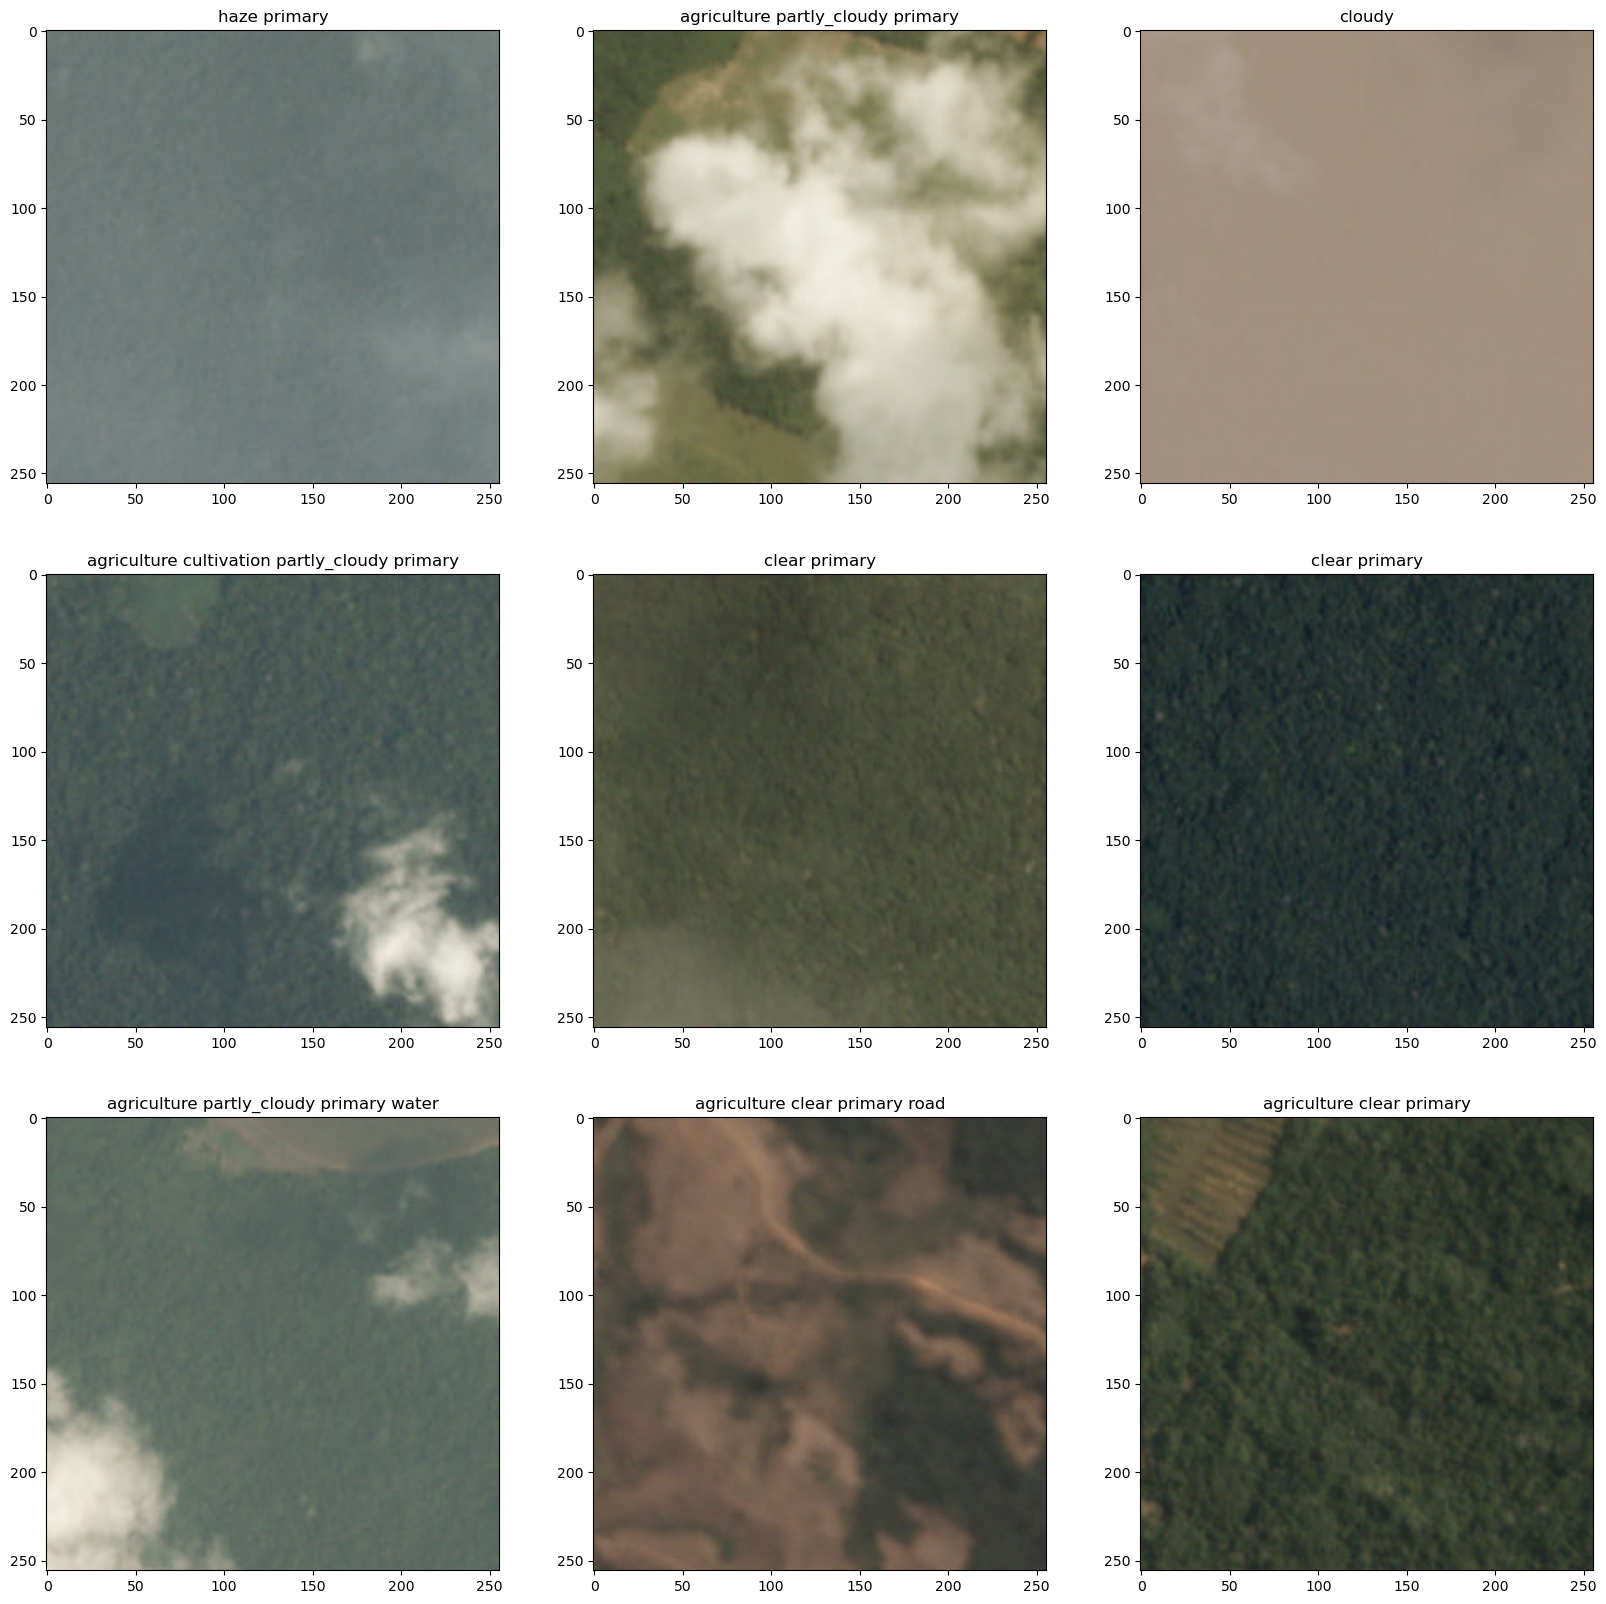

In [6]:
fig,ax = plt.subplots(3,3, figsize = (20,20))
for i,j in enumerate(np.random.randint(0,train.shape[0],9)):
    image_path = '/kaggle/input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(str(j))
    img = cv2.imread(image_path)
    ax[int(i/3),i%3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[int(i/3),i%3].set_title(train.iloc[j,1])

##  Encoding and Processing

In [7]:
x_train = []
y_train = []

for x, tags in tqdm(train.values, miniters=1500):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(x))
    targets = np.zeros(17)
    for tag in tags.split(' '):
        targets[dic[tag]] = 1
    x_train.append(cv2.resize(img, (32,32)))
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [09:25<00:00, 71.62it/s] 


(40479, 32, 32, 3)
(40479, 17)


### Splitting data

In [8]:
split = 33000
x_train, x_test, y_train, y_test = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

# 1st  Model Training

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                activation='relu',
                input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

In [10]:
history = model.fit(x_train, y_train,
             batch_size=128,
             epochs=6,
             verbose=1,
             validation_data=(x_test, y_test))

Epoch 1/6
258/258 [==============================] - 73s 277ms/step - loss: 0.2520 - accuracy: 0.1170 - val_loss: 0.1986 - val_accuracy: 0.1095
Epoch 2/6
258/258 [==============================] - 71s 274ms/step - loss: 0.2046 - accuracy: 0.1197 - val_loss: 0.1847 - val_accuracy: 0.1198
Epoch 3/6
258/258 [==============================] - 70s 272ms/step - loss: 0.1907 - accuracy: 0.1232 - val_loss: 0.1756 - val_accuracy: 0.1119
Epoch 4/6
258/258 [==============================] - 70s 273ms/step - loss: 0.1819 - accuracy: 0.1310 - val_loss: 0.1691 - val_accuracy: 0.1124
Epoch 5/6
258/258 [==============================] - 71s 274ms/step - loss: 0.1768 - accuracy: 0.1391 - val_loss: 0.1660 - val_accuracy: 0.1185
Epoch 6/6
258/258 [==============================] - 70s 272ms/step - loss: 0.1730 - accuracy: 0.1454 - val_loss: 0.1637 - val_accuracy: 0.1122


## Evaluation of  Model

In [11]:
valid = model.predict(x_test, batch_size=128)
print(fbeta_score(y_test, np.array(valid) > 0.2, beta=2, average='samples'))

59/59 [==============================] - 3s 56ms/step
0.8407956738094557


Text(0.5, 1.0, 'Loss Curves - before tweaking')

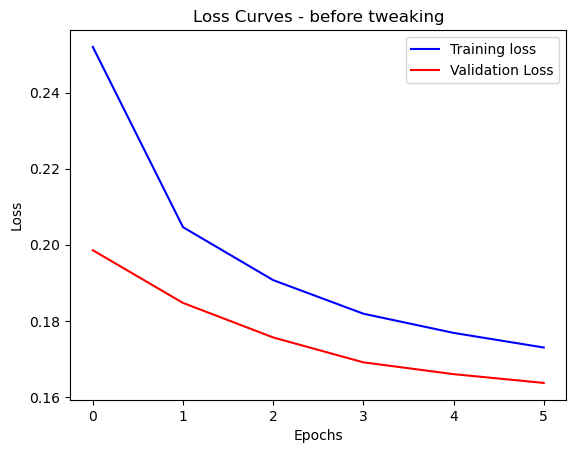

In [12]:
# Visualize Loss

plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - before tweaking')

## 2 nd Model Training (Add more layers)


In [13]:
model = Sequential()
# Block 1
model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#Block 2
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#Block 3
model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
history = model.fit(x_train, y_train,
                 batch_size=128,
                 epochs=6,
                 verbose=1,
                 validation_data=(x_test, y_test))

Epoch 1/6
258/258 [==============================] - 135s 516ms/step - loss: 0.2166 - accuracy: 0.1097 - val_loss: 0.1686 - val_accuracy: 0.0964
Epoch 2/6
258/258 [==============================] - 130s 506ms/step - loss: 0.1615 - accuracy: 0.1048 - val_loss: 0.1488 - val_accuracy: 0.0955
Epoch 3/6
258/258 [==============================] - 130s 505ms/step - loss: 0.1439 - accuracy: 0.1027 - val_loss: 0.1379 - val_accuracy: 0.1005
Epoch 4/6
258/258 [==============================] - 130s 503ms/step - loss: 0.1347 - accuracy: 0.1117 - val_loss: 0.1353 - val_accuracy: 0.1058
Epoch 5/6
258/258 [==============================] - 130s 505ms/step - loss: 0.1288 - accuracy: 0.1141 - val_loss: 0.1270 - val_accuracy: 0.1195
Epoch 6/6
258/258 [==============================] - 130s 506ms/step - loss: 0.1231 - accuracy: 0.1178 - val_loss: 0.1248 - val_accuracy: 0.1197


# Evaluation of  Model

In [15]:
valid = model.predict(x_test, batch_size=128)
print(fbeta_score(y_test, np.array(valid) > 0.2, beta=2, average='samples'))

59/59 [==============================] - 7s 111ms/step
0.8895204027269593


Text(0.5, 1.0, 'Loss Curves - after tweaking')

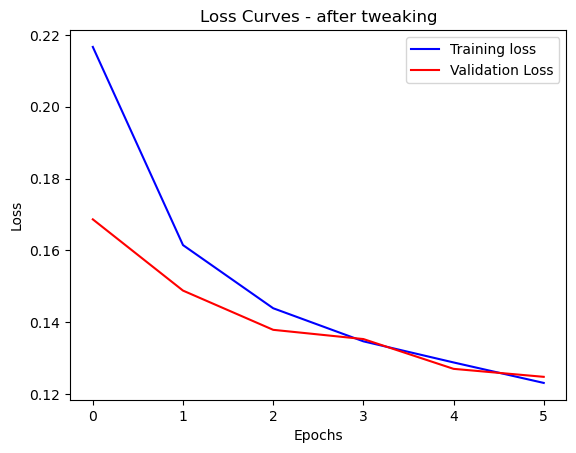

In [16]:
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after tweaking')

# Implementing  Model on test data

In [17]:
x_test = []
x_test_add = []
img_title = []
img_title_add = []

for x in tqdm(listdir('/kaggle/input/planets-dataset/planet/planet/test-jpg'), miniters=1500):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (32,32)))
    img_title.append(img_name)
    
for x in tqdm(listdir('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'), miniters=1500):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img_name))
    x_test_add.append(cv2.resize(img, (32,32)))
    img_title_add.append(img_name)
    
x_test = np.array(x_test, np.float16) / 255
x_test_add = np.array(x_test_add, np.float16) / 255

100%|██████████| 20522/20522 [05:16<00:00, 64.75it/s]


In [18]:
pred1 = model.predict(x_test, batch_size=128)
pred2 = model.predict(x_test_add, batch_size=128)

161/161 [==============================] - 19s 115ms/step


In [19]:
image1 = []
tags1 = []
for i, img in enumerate(img_title):
    image1.append(img)
    tags1.append(' '.join(np.array(labels)[pred1[i] > 0.2]))
df1 = pd.DataFrame()
df1['image_name'] = image1
df1['tags'] = tags1

image2 = []
tags2 = []
for i, img in enumerate(img_title_add):
    image2.append(img)
    tags2.append(' '.join(np.array(labels)[pred2[i] > 0.2]))
df2 = pd.DataFrame()
df2['image_name'] = image2
df2['tags'] = tags2

In [20]:
full_df = pd.concat([df1, df2])
full_df

image_name                                               tags
0      test_39140   road agriculture water clear primary cultivation
1       test_4849                                 haze clear primary
2      test_18979  road agriculture water clear primary cultivati...
3      test_24790                     road agriculture clear primary
4      test_30624                                      clear primary
...           ...                                                ...
20517   file_6101                              primary partly_cloudy
20518   file_7113                                      clear primary
20519   file_9271               road agriculture water clear primary
20520  file_13908  road agriculture water clear primary cultivati...
20521   file_8496  road agriculture clear primary cultivation hab...

[61191 rows x 2 columns]

## Saving The output to  submission file

In [21]:
full_df.to_csv('submission.csv', index=False)

In [22]:
pd.read_csv('/kaggle/working/submission.csv')

image_name                                               tags
0      test_39140   road agriculture water clear primary cultivation
1       test_4849                                 haze clear primary
2      test_18979  road agriculture water clear primary cultivati...
3      test_24790                     road agriculture clear primary
4      test_30624                                      clear primary
...           ...                                                ...
61186   file_6101                              primary partly_cloudy
61187   file_7113                                      clear primary
61188   file_9271               road agriculture water clear primary
61189  file_13908  road agriculture water clear primary cultivati...
61190   file_8496  road agriculture clear primary cultivation hab...

[61191 rows x 2 columns]